# Compare
1. BPR: Bayesian Personalized Ranking from Implicit Feedback
https://arxiv.org/abs/1205.2618
2. (WARP) WSABIE: Scaling Up To Large Vocabulary Image Annotation http://www.thespermwhale.com/jaseweston/papers/wsabie-ijcai.pdf
3. (k-OS WARP) Learning to Rank Recommendations with the k-Order Statistic Loss https://research.google.com/pubs/pub41534.html
4. CLiMF: Learning to Maximize Reciprocal Rank with Collaborative Less-is-More Filtering
http://baltrunas.info/papers/Shi12-climf.pdf

### Data
- Movielens 100k https://grouplens.org/datasets/movielens/100k/
- README - http://files.grouplens.org/datasets/movielens/ml-100k-README.txt

## TODO
- speed up implementations (cython, c++, or numba/bottleneck)
- use better optimizers (Adam, Nesterov, AdaGrad/Delta)

In [1]:
import os
import pandas as pd
from scipy.sparse import coo_matrix, csr_matrix, diags
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import log_loss, accuracy_score, roc_curve, roc_auc_score
from sklearn.utils.extmath import safe_sparse_dot
import time
import math

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from warp import WARPNaive, KosWARP
from bpr import BPR
from climf import CLiMF

In [4]:
dtype = np.float32

In [5]:
data_dir = "/Users/timwee/projects/datasets/movielens/ml-100k"

def load_data_from_f(fpath):
    # columns - user id | item id | rating | timestamp
    # user_id and item_id numbered consecutively from 1
    with open(fpath) as f:
        users, items, ratings = [], [], []
        max_user = -1
        max_item = -1
        for line in f:
            user_id, item_id, rating, ts = [int(tok) for tok in line.strip().split("\t")]
            # make it zero indexed
            user_id -= 1
            item_id -= 1
            max_user = max(max_user, user_id)
            max_item = max(max_item, item_id)
            users.append(user_id) 
            items.append(item_id)
            ratings.append(rating)
        return np.array(users), np.array(items), np.array(ratings), max_user, max_item


def train_and_test_data(data_dir, train_fname="ua.base", test_fname="ua.test", dtype=np.float32):
    trn_u, trn_i, trn_r, max_trn_u, max_trn_i = load_data_from_f(os.path.join(data_dir, train_fname))
    tst_u, tst_i, tst_r, max_tst_u, max_tst_i = load_data_from_f(os.path.join(data_dir, test_fname))
    num_rows = max(max_trn_u, max_tst_u) + 1
    num_cols = max(max_trn_i, max_tst_i) + 1
    return {"train" : coo_matrix((trn_r, (trn_u, trn_i)), shape=(num_rows, num_cols), dtype=dtype).tocsr(), \
            "test" : coo_matrix((tst_r, (tst_u, tst_i)), shape=(num_rows, num_cols), dtype=dtype).tocsr()}
    

In [6]:
movielens = train_and_test_data(data_dir, dtype=dtype)
train, test = movielens["train"], movielens["test"]
num_users, num_items = train.shape
train.shape, test.shape

((943, 1682), (943, 1682))

### learning rate decay

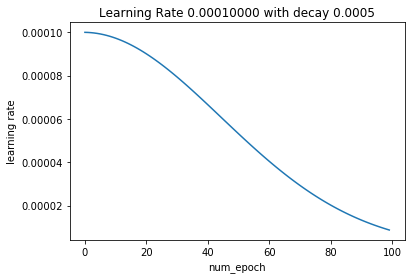

In [16]:
lrate = 1e-4
decay = 5e-4
lr_val = [lrate]
for i in range(1, 100):
    lr_val.append(lr_val[i-1] * (1. / (1. + (decay * i))))
plt.plot(np.arange(100), lr_val)
plt.xlabel("num_epoch")
plt.ylabel("learning rate")
plt.title("Learning Rate %.8f with decay %.4f" % (lrate, decay))
plt.show()

## helpers

In [8]:
def plot_auc(title, auc_scores, num_epochs):
    epoch_x = np.arange(num_epochs)
    test_line, = plt.plot(epoch_x, auc_scores, label="auc test")
    plt.legend([test_line], ["test auc"])
    plt.xlabel("num_epoch")
    plt.ylabel("auc_score")
    plt.title(title)
    plt.show()

In [26]:
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k, reciprocal_rank

In [10]:
num_epochs = 100
eval_interval = 10

# KOS Warp

In [11]:
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k

durations = []
tst_koswarp_auc = []
tst_koswarp_prec5 = []
tst_koswarp_rr = []

kos_model = KosWARP(lr=5e-7, item_reg=0.2, user_reg=0.2)
for epoch in range(num_epochs+1):
    start = time.time()
    kos_model.fit(train, reset=False)
    if (epoch % eval_interval) == 0 or epoch == num_epochs:
        duration = time.time() - start
        durations.append(duration)    
        tst_auc = auc_score(kos_model, test, train_interactions=train).mean()
        tst_prec5 = precision_at_k(kos_model, test, train_interactions=train, k=5).mean()
        tst_rr = reciprocal_rank(kos_model, test, train_interactions=train).mean()
        tst_koswarp_auc.append(tst_auc)
        tst_koswarp_prec5.append(tst_prec5)
        tst_koswarp_rr.append(tst_rr)
        print("iteration %d took %.4f, auc: %.4f, p@5: %.4f, rr: %.4f" % \
              (epoch, duration, tst_auc, tst_prec5, tst_rr))

initializing embeddings and biases
iteration 0 took 7.9546, auc: 0.6811, p@5: 0.0397, rr: 0.1360
iteration 10 took 8.1954, auc: 0.8241, p@5: 0.0549, rr: 0.1679
iteration 20 took 8.1165, auc: 0.8273, p@5: 0.0551, rr: 0.1682
iteration 30 took 8.1553, auc: 0.8275, p@5: 0.0522, rr: 0.1673
iteration 40 took 8.1103, auc: 0.8281, p@5: 0.0532, rr: 0.1611
iteration 50 took 8.0387, auc: 0.8286, p@5: 0.0562, rr: 0.1678
iteration 60 took 8.0135, auc: 0.8283, p@5: 0.0541, rr: 0.1685
iteration 70 took 8.1162, auc: 0.8288, p@5: 0.0547, rr: 0.1734
iteration 80 took 8.0889, auc: 0.8285, p@5: 0.0537, rr: 0.1709
iteration 90 took 8.1124, auc: 0.8277, p@5: 0.0534, rr: 0.1667


# CLiMF

In [12]:
durations = []
tst_climf_auc = []
tst_climf_prec5 = []
tst_climf_rr = []

# override lr
lrate = 1e-4
decay = 5e-4

climf_model = CLiMF(lr=1e-4, reg=0.001)
for epoch in range(num_epochs+1):
    start = time.time()
    climf_model.fit(train, lr=lrate, debug=False, reset=False)
    lrate *= (1. / (1. + (decay * i)))
    duration = time.time() - start
    if (epoch % eval_interval) == 0 or epoch == num_epochs:
        durations.append(duration)    
        tst_auc = auc_score(climf_model, test, train_interactions=train).mean()
        tst_prec5 = precision_at_k(climf_model, test, train_interactions=train, k=5).mean()
        tst_rr = reciprocal_rank(climf_model, test, train_interactions=train).mean()
        tst_climf_auc.append(tst_auc)
        tst_climf_prec5.append(tst_prec5)
        tst_climf_rr.append(tst_rr)
        print("iteration %d took %.4f, auc: %.4f, p@5: %.4f, rr: %.4f" % \
              (epoch, duration, tst_auc, tst_prec5, tst_rr))

initializing embeddings
iteration 0 took 9.0213, auc: 0.4995, p@5: 0.0062, rr: 0.0342
iteration 10 took 9.3370, auc: 0.5213, p@5: 0.0191, rr: 0.0725
iteration 20 took 9.1028, auc: 0.5632, p@5: 0.0386, rr: 0.1095
iteration 30 took 9.1309, auc: 0.6008, p@5: 0.0522, rr: 0.1433
iteration 40 took 9.0532, auc: 0.6266, p@5: 0.0607, rr: 0.1661
iteration 50 took 9.6576, auc: 0.6422, p@5: 0.0687, rr: 0.1838
iteration 60 took 9.6209, auc: 0.6512, p@5: 0.0734, rr: 0.1956
iteration 70 took 9.2395, auc: 0.6565, p@5: 0.0764, rr: 0.2006
iteration 80 took 9.5704, auc: 0.6598, p@5: 0.0772, rr: 0.2028
iteration 90 took 9.2310, auc: 0.6617, p@5: 0.0778, rr: 0.2043
iteration 100 took 9.0222, auc: 0.6629, p@5: 0.0780, rr: 0.2067


## WARP

In [13]:
durations = []
tst_warp_auc = []
tst_warp_prec5 = []
tst_warp_rr = []


model = WARPNaive(lr=1e-6, item_reg=0.2, user_reg=0.2)

for epoch in range(num_epochs+1):
    start = time.time()
    model.fit(train, reset=False)
    if (epoch % eval_interval) == 0 or epoch == num_epochs:
        duration = time.time() - start
        durations.append(duration)    
        tst_auc = auc_score(model, test, train_interactions=train).mean()
        tst_prec5 = precision_at_k(model, test, train_interactions=train, k=5).mean()
        tst_rr = reciprocal_rank(model, test, train_interactions=train).mean()
        tst_warp_auc.append(tst_auc)
        tst_warp_prec5.append(tst_prec5)
        tst_warp_rr.append(tst_rr)
        print("warp iteration %d took %.4f, auc: %.4f, p@5: %.4f, rr: %.4f" % \
              (epoch, duration, tst_auc, tst_prec5, tst_rr))

initializing embeddings and biases
warp iteration 0 took 5.1755, auc: 0.6210, p@5: 0.0308, rr: 0.1010
warp iteration 10 took 4.6795, auc: 0.7651, p@5: 0.0407, rr: 0.1388
warp iteration 20 took 4.6546, auc: 0.7836, p@5: 0.0424, rr: 0.1510
warp iteration 30 took 4.7072, auc: 0.7910, p@5: 0.0420, rr: 0.1542
warp iteration 40 took 4.6532, auc: 0.7942, p@5: 0.0418, rr: 0.1572
warp iteration 50 took 4.7786, auc: 0.7955, p@5: 0.0418, rr: 0.1581
warp iteration 60 took 4.7072, auc: 0.7962, p@5: 0.0418, rr: 0.1588
warp iteration 70 took 4.6599, auc: 0.7969, p@5: 0.0416, rr: 0.1591
warp iteration 80 took 4.7809, auc: 0.7969, p@5: 0.0418, rr: 0.1587
warp iteration 90 took 4.8022, auc: 0.7972, p@5: 0.0416, rr: 0.1582


## BPR Class

In [18]:
durations = []
tst_bpr_auc = []
tst_bpr_prec5 = []
tst_bpr_rr = []

bpr_model = BPR(lr=5e-7, item_reg=0.2, user_reg=0.2)
for epoch in range(num_epochs + 1):
    start = time.time()
    bpr_model.fit(train, reset=False)
    if (epoch % eval_interval) == 0 or epoch == num_epochs:
        duration = time.time() - start
        durations.append(duration)    
        tst_auc = auc_score(bpr_model, test, train_interactions=train).mean()
        tst_prec5 = precision_at_k(bpr_model, test, train_interactions=train, k=5).mean()
        tst_rr = reciprocal_rank(bpr_model, test, train_interactions=train).mean()
        tst_bpr_auc.append(tst_auc)
        tst_bpr_prec5.append(tst_prec5)
        tst_bpr_rr.append(tst_rr)
        print("iteration %d took %.4f, auc: %.4f, p@5: %.4f, rr: %.4f" % (epoch, duration, tst_auc, tst_prec5, tst_rr))

initializing embeddings and biases
iteration 0 took 5.5876, auc: 0.5139, p@5: 0.0085, rr: 0.0391
iteration 10 took 5.1454, auc: 0.6149, p@5: 0.0284, rr: 0.0938
iteration 20 took 5.2928, auc: 0.6667, p@5: 0.0320, rr: 0.0999
iteration 30 took 5.1436, auc: 0.7014, p@5: 0.0331, rr: 0.1071
iteration 40 took 5.0596, auc: 0.7265, p@5: 0.0354, rr: 0.1119
iteration 50 took 5.5074, auc: 0.7445, p@5: 0.0371, rr: 0.1180
iteration 60 took 5.1390, auc: 0.7578, p@5: 0.0378, rr: 0.1222
iteration 70 took 5.2431, auc: 0.7676, p@5: 0.0388, rr: 0.1309
iteration 80 took 5.6603, auc: 0.7752, p@5: 0.0407, rr: 0.1414
iteration 90 took 5.5917, auc: 0.7808, p@5: 0.0409, rr: 0.1481


# compare algos

### reciprocal rank

Note: CLiMF optimizes for Reciprocal Rank directly.

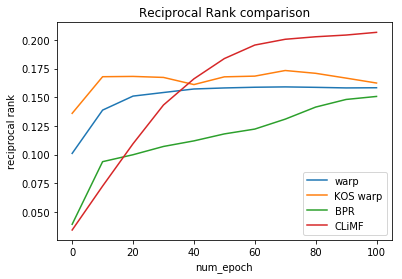

In [23]:
epoch_x = np.arange(len(tst_warp_rr)) * eval_interval
warp_line, = plt.plot(epoch_x, tst_warp_rr, label="WARP")
koswarp_line, = plt.plot(epoch_x, tst_koswarp_rr, label="KOS WARP")
bpr_line, = plt.plot(epoch_x, tst_bpr_rr, label="BPR")
climf_line, = plt.plot(epoch_x, tst_climf_rr, label="CLiMF")
plt.legend([warp_line, koswarp_line, bpr_line, climf_line], \
           ["warp", "KOS warp", "BPR", "CLiMF"])
plt.xlabel("num_epoch")
plt.ylabel("reciprocal rank")
plt.title("Reciprocal Rank comparison")
plt.show()

### P@5

WARP and k-OS WARP optimize for p@5. 

Reciprocal rank is somewhat related to it too, since it optimizes for the top of the list.

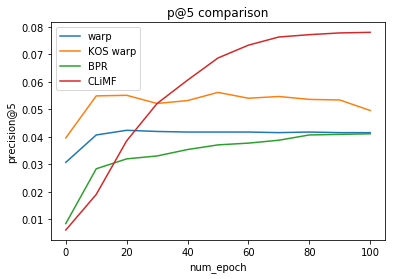

In [24]:
epoch_x = np.arange(len(tst_warp_prec5)) * eval_interval
warp_line, = plt.plot(epoch_x, tst_warp_prec5, label="WARP")
koswarp_line, = plt.plot(epoch_x, tst_koswarp_prec5, label="KOS WARP")
bpr_line, = plt.plot(epoch_x, tst_bpr_prec5, label="BPR")
climf_line, = plt.plot(epoch_x, tst_climf_prec5, label="CLiMF")
plt.legend([warp_line, koswarp_line, bpr_line, climf_line], \
           ["warp", "KOS warp", "BPR", "CLiMF"])
plt.xlabel("num_epoch")
plt.ylabel("precision@5")
plt.title("p@5 comparison")
plt.show()

### AUC

BPR optimizes for AUC, CLiMF does not. (AUC optimizes across the entire list, reciprocal rank is for the top of the list)

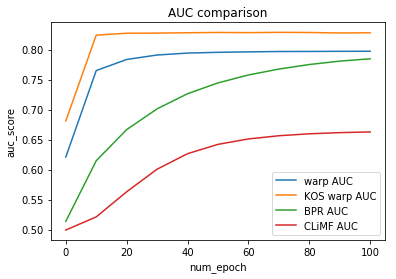

In [25]:
epoch_x = np.arange(len(tst_warp_auc)) * eval_interval
warp_line, = plt.plot(epoch_x, tst_warp_auc, label="WARP")
koswarp_line, = plt.plot(epoch_x, tst_koswarp_auc, label="KOS WARP")
bpr_line, = plt.plot(epoch_x, tst_bpr_auc, label="BPR")
climf_line, = plt.plot(epoch_x, tst_climf_auc, label="CLiMF")
plt.legend([warp_line, koswarp_line, bpr_line, climf_line], \
           ["warp AUC", "KOS warp AUC", "BPR AUC", "CLiMF AUC"])
plt.xlabel("num_epoch")
plt.ylabel("auc_score")
plt.title("AUC comparison")
plt.show()